In [1]:
import pandas as pd
df_train = pd.read_csv('df_train_sbert.csv')
df_test = pd.read_csv('df_test_sbert.csv')

In [4]:
import numpy as np

# Function to safely convert string embeddings to numpy arrays
def parse_embedding(embedding):
    if isinstance(embedding, str):  # If stored as a string
        embedding = embedding.replace("[", "").replace("]", "")  # Remove brackets
        return np.array([float(x) for x in embedding.split()])  # Convert to float array
    return np.array(embedding)  # If already numeric, keep as is

# Convert all embeddings properly
df_train["sbert_embedding"] = df_train["sbert_embedding"].apply(parse_embedding)
df_test["sbert_embedding"] = df_test["sbert_embedding"].apply(parse_embedding)


In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Convert embeddings (lists) to numpy arrays
X_train = np.vstack(df_train["sbert_embedding"].values)
X_test = np.vstack(df_test["sbert_embedding"].values)

# Labels
y_train = df_train["label"].values
y_test = df_test["label"].values

# Logistic Regression with hyperparameter tuning
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}  # Regularization strength
log_reg = GridSearchCV(LogisticRegression(max_iter=1000, class_weight="balanced"), param_grid, cv=5, scoring="f1")
log_reg.fit(X_train, y_train)

# Best model
best_model = log_reg.best_estimator_
print(f"Best C: {log_reg.best_params_['C']}")

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best C: 1
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.86      0.91     18301
        True       0.58      0.88      0.70      3927

    accuracy                           0.87     22228
   macro avg       0.77      0.87      0.81     22228
weighted avg       0.90      0.87      0.88     22228

Confusion Matrix:
 [[15773  2528]
 [  460  3467]]


The low score of true is due to imbalance of data. But I think using 'balanced' in class weight is already a strong enough move, given we don't know the generative model.

turn to something non-linear

In [6]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

### 🌲 1️⃣ RANDOM FOREST CLASSIFIER
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

### 🚀 2️⃣ XGBOOST CLASSIFIER
# Compute class imbalance ratio
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n🔹 XGBoost Results")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

### 🎯 Feature Importance Analysis (Random Forest)
importances = rf.feature_importances_
top_features = np.argsort(importances)[::-1][:10]  # Top 10 features

print("\n🔹 Top 10 Important Features (Random Forest)")
print(top_features, importances[top_features])


🔹 Random Forest Results
              precision    recall  f1-score   support

       False       0.89      0.97      0.93     18301
        True       0.78      0.45      0.57      3927

    accuracy                           0.88     22228
   macro avg       0.84      0.71      0.75     22228
weighted avg       0.87      0.88      0.87     22228

Confusion Matrix:
 [[17805   496]
 [ 2157  1770]]


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:00:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732667231635/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Results
              precision    recall  f1-score   support

       False       0.97      0.88      0.92     18301
        True       0.60      0.86      0.71      3927

    accuracy                           0.87     22228
   macro avg       0.78      0.87      0.81     22228
weighted avg       0.90      0.87      0.88     22228

Confusion Matrix:
 [[16022  2279]
 [  538  3389]]

🔹 Top 10 Important Features (Random Forest)
[ 79 155 262 287 353 247  21 376 309 361] [0.03764765 0.0307597  0.02384917 0.02144387 0.02098861 0.01911666
 0.01662174 0.01519064 0.01410933 0.01346176]


so far it seems like RF is biased towards false, while XGB is more balanced.

In [11]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# Define the search space (fewer parameters for efficiency)
param_grid = {
    "max_depth": [3, 5, 7],  # Prevent overfitting
    "learning_rate": [0.05, 0.1],  # Controls weight update smoothness
    "n_estimators": [100, 200]  # Limits boosting rounds
}

# Initialize XGBoost classifier
xgb = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    eval_metric="logloss",
    #use_label_encoder=False,
    n_jobs=-1
)

# Grid search with fewer parameters
grid_search = GridSearchCV(
    xgb, param_grid, scoring="f1", cv=5, n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model from tuning
best_xgb = grid_search.best_estimator_
print(f"🔹 Best Params: {grid_search.best_params_}")

# Predict on test set
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate performance
print("\n🔹 Tuned XGBoost Results")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


🔹 Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

🔹 Tuned XGBoost Results
              precision    recall  f1-score   support

       False       0.93      0.96      0.94     18301
        True       0.78      0.65      0.71      3927

    accuracy                           0.91     22228
   macro avg       0.85      0.81      0.83     22228
weighted avg       0.90      0.91      0.90     22228

Confusion Matrix:
 [[17574   727]
 [ 1369  2558]]


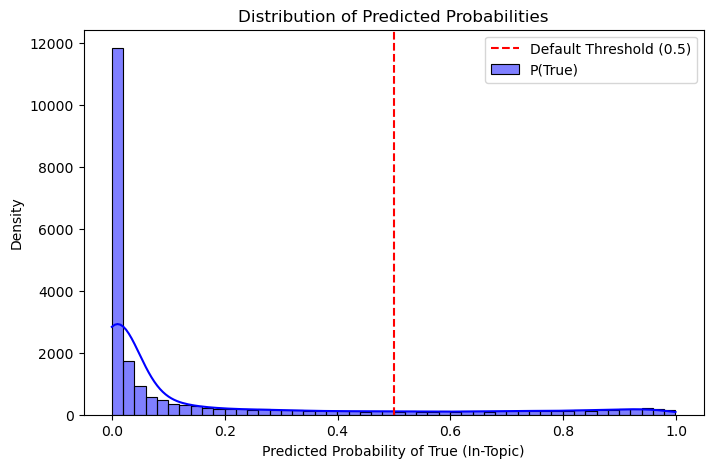

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get prediction probabilities for class "True"
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Plot probability distribution
plt.figure(figsize=(8,5))
sns.histplot(y_prob, bins=50, kde=True, color="blue", label="P(True)")
plt.axvline(0.5, color="red", linestyle="--", label="Default Threshold (0.5)")
plt.xlabel("Predicted Probability of True (In-Topic)")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Predicted Probabilities")
plt.show()


In [10]:
# logistic on XGB to fix the overconfidence on false label
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Get XGBoost probability predictions
y_prob_train = best_xgb.predict_proba(X_train)[:, 1].reshape(-1, 1)
y_prob_test = best_xgb.predict_proba(X_test)[:, 1].reshape(-1, 1)

# Train logistic regression on XGBoost probabilities
log_reg = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced", max_iter=1000))
log_reg.fit(y_prob_train, y_train)

# Predict
y_pred_ensemble = log_reg.predict(y_prob_test)

print("\n🔹 XGBoost + Logistic Regression Ensemble Results")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))



🔹 XGBoost + Logistic Regression Ensemble Results
              precision    recall  f1-score   support

       False       0.95      0.94      0.94     18301
        True       0.72      0.76      0.74      3927

    accuracy                           0.91     22228
   macro avg       0.83      0.85      0.84     22228
weighted avg       0.91      0.91      0.91     22228

Confusion Matrix:
 [[17127  1174]
 [  930  2997]]


slightly better than pure XGB, more balanced.

In [13]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.6 MB/s eta 0:00:00


In [14]:
#light gbm to fix overconfidence
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, class_weight="balanced", random_state=42)
lgbm.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgbm.predict(X_test)

print("\n🔹 LightGBM Results")
print(classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 15487, number of negative: 73424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 88911, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "max_depth": [3, 5, 7],  # Control complexity
    "learning_rate": [0.05, 0.1, 0.2],  # Step size
    "n_estimators": [100, 200, 300],  # More boosting rounds
    "min_child_samples": [10, 20, 30],  # Avoid overfitting
    "subsample": [0.8, 1.0],  # Reduce variance
}

# Initialize LightGBM
lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

# Grid search with fewer params for efficiency
grid_search = GridSearchCV(
    lgbm, param_grid, scoring="f1", cv=3, verbose=2, n_jobs=-1
)

# Train model
grid_search.fit(X_train, y_train)

# Best model from tuning
best_lgbm = grid_search.best_estimator_
print(f"🔹 Best Params: {grid_search.best_params_}")

# Predict on test set
y_pred_lgbm = best_lgbm.predict(X_test)

# Evaluate performance
print("\n🔹 Tuned LightGBM Results")
print(classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))


# Model Comparison & Final Recommendations

We compared four models on our binary classification task (In-Topic vs. Out-of-Topic) using SBERT embeddings. The models and their key metrics are summarized in the table below:

| **Metric**                  | **Logistic Regression** | **XGBoost Tuned**  | **XGB + Logistic Ensemble** | **LightGBM**  |
|-----------------------------|-------------------------|--------------------|-----------------------------|---------------|
| **Overall Accuracy**        | 87%                     | 91%                | 91%                         | 88%           |
| **Precision (True)**        | 0.58                    | 0.78               | 0.72                        | 0.61          |
| **Recall (True)**           | 0.88                    | 0.65               | 0.76                        | 0.87          |
| **F1-Score (True)**         | 0.70                    | 0.71               | 0.74                        | 0.71          |
| **Confusion Matrix**        | [[15773, 2528], [460, 3467]] | [[17574, 727], [1369, 2558]] | [[17127, 1174], [930, 2997]] | [[16095, 2206], [530, 3397]] |

---

## Analysis by Case

1. **Logistic Regression:**
   - **Strength:** 
     - Very high recall for the True (In-Topic) class (0.88) → catches nearly all In-Topic quotes.
   - **Weakness:** 
     - Low precision (0.58) leads to many false positives.
   - **When to Use:** 
     - If missing an In-Topic quote is highly undesirable, even at the expense of extra false alarms.

2. **XGBoost Tuned:**
   - **Strength:** 
     - High precision (0.78) for the True class → when it predicts In-Topic, it's quite reliable.
     - Overall accuracy of 91%.
   - **Weakness:** 
     - Lower recall (0.65) indicates a risk of missing a number of In-Topic quotes.
   - **When to Use:** 
     - If false positives are costly and you want to be more confident when predicting True, even if it means missing some positives.

3. **XGB + Logistic Ensemble:**
   - **Strength:** 
     - Provides a balanced trade-off: precision of 0.72 and recall of 0.76, resulting in the highest F1-score (0.74) for the True class.
     - Overall accuracy remains at 91%.
   - **Weakness:** 
     - The ensemble adds complexity to the pipeline.
   - **When to Use:** 
     - If you want a well-balanced model that doesn't overcommit to either extreme (overconfidence or excessive leniency on True).
  
4. **LightGBM:**
   - **Strength:** 
     - Very high recall (0.87) for the True class, ensuring most In-Topic quotes are caught.
   - **Weakness:** 
     - Lower precision (0.61) means more false positives.
     - Overall accuracy is a bit lower (88%).
   - **When to Use:** 
     - If the priority is to capture as many In-Topic quotes as possible, even if it means accepting a higher rate of false positives.

---

## **Final Recommendation**

- **Best Overall Balance:**  
  The **XGB + Logistic Ensemble** provides the best overall balance with an F1-score of **0.74** for the True class and an overall accuracy of **91%**. This approach minimizes the risk of overconfidence on the True class (unlike XGBoost alone) and avoids the extreme false positives seen with Logistic Regression.

- **Considerations:**  
  - If **false positives are a major concern**, you might lean towards **XGBoost Tuned** despite its lower recall.
  - If **maximizing recall is critical**, then **LightGBM** or even Logistic Regression might be preferable, though at the cost of precision.
  - Given our current data and without further knowledge of the generative distribution, the ensemble is a robust, balanced choice.

**Conclusion:**  
For our use case, where we want to balance the risks of overconfidence on the True (In-Topic) class while maintaining high overall accuracy, the **XGB + Logistic Ensemble** appears to be the best option. Further fine-tuning might yield marginal improvements, but the ensemble already meets a good balance between precision and recall.

---

*Feel free to adjust based on any additional business or application requirements!*
